<a href="https://colab.research.google.com/github/lazy-wolf/python-class-notes/blob/main/Kaggle_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image as Image
import tensorflow_datasets as tfds
import pandas as pd

In [ ]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import accuracy_score

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
directory = "/content/drive/MyDrive/TME_6015/Assignment_2/Mango_Leaf_Disease"
batch_size = 32
img_height = 128
img_width = 128
train_data = tf.keras.utils.image_dataset_from_directory(directory,
                                                         validation_split=0.2,
                                                         seed=123,
                                                         subset="training",
                                                         image_size=(img_height, img_width),
                                                         batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 3200 files for training.


In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_names =train_data.class_names
print(class_names)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(directory,
                                                       validation_split=0.2,
                                                       subset="validation",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size)

Found 4000 files belonging to 8 classes.
Using 800 files for validation.


In [ ]:
val_data.class_names

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

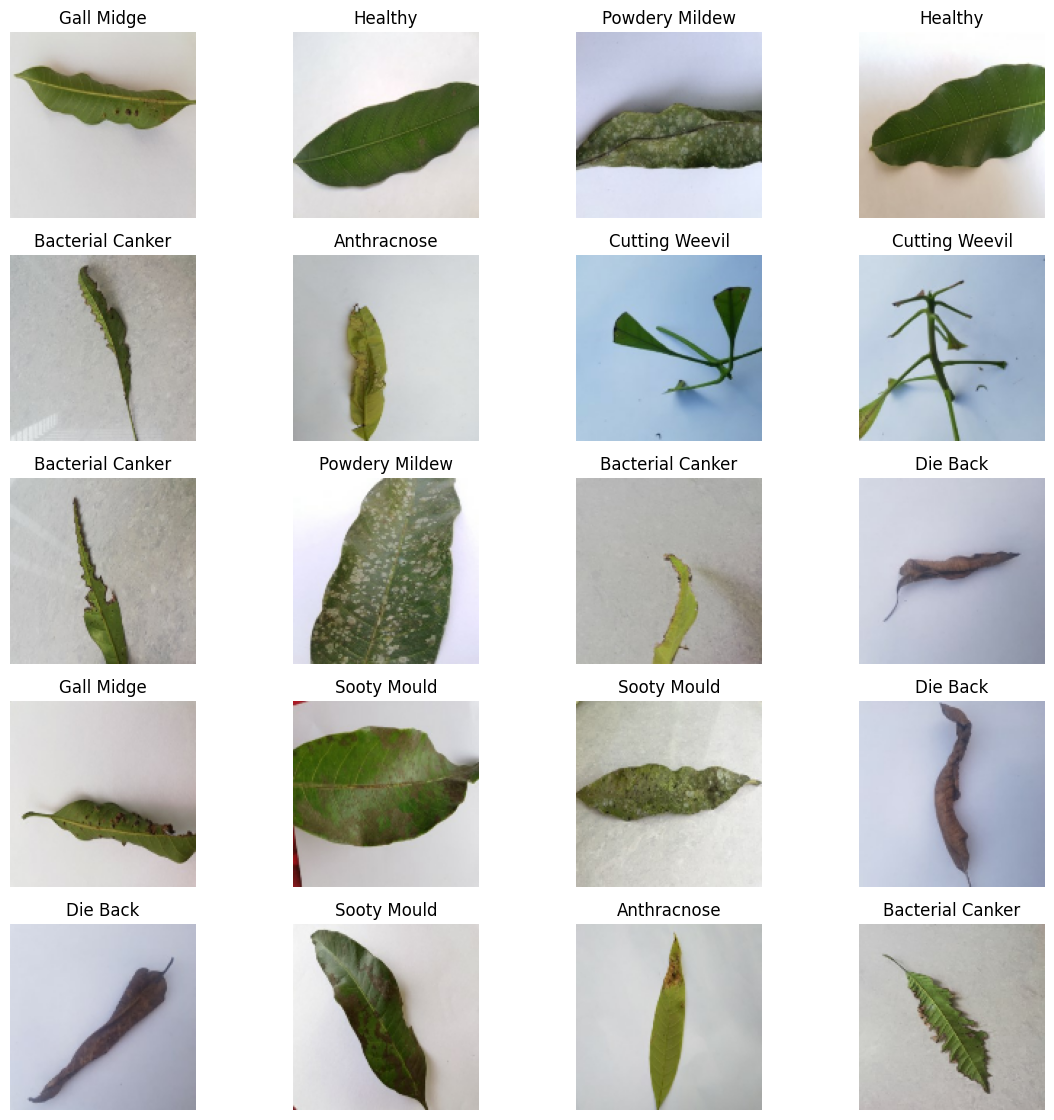

In [ ]:
plt.figure(figsize=(14, 14))
for images, labels in train_data.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
model_handle = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

feature_extractor = hub.KerasLayer(model_handle,
                                   trainable=True)
num_class = 8
model = tf.keras.Sequential(
    [
        normalization_layer,
        feature_extractor,
        tf.keras.layers.Dense(num_class, activation="softmax")
    ]
)
model.build([None, 128, 128, 3])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 keras_layer_5 (KerasLayer)  (None, 1001)              1692489   
                                                                 
 dense_5 (Dense)             (None, 8)                 8016      
                                                                 
Total params: 1700505 (6.49 MB)
Trainable params: 1686425 (6.43 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), # different loss function for multiclass classifcation
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"]
             )


# Callbacks--> Stop training automatically once the model performance stop improving
learning_rate_reduction=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=2,factor=0.5, min_lr=0.00001,verbose =1)
Early_Stopping= tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)

# Fit the model
history1= model.fit(train_data, epochs=20, validation_data= val_data,callbacks=[Early_Stopping,learning_rate_reduction], verbose=1)

Epoch 1/20
100/100 [==============================] - 630s 6s/step - loss: 0.7205 - accuracy: 0.8803 - val_loss: 4.1112 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 47s 463ms/step - loss: 0.4049 - accuracy: 0.9478 - val_loss: 1.6935 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 46s 453ms/step - loss: 0.2344 - accuracy: 0.9641 - val_loss: 0.2672 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 47s 469ms/step - loss: 0.1660 - accuracy: 0.9791 - val_loss: 0.3842 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9694
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 [==============================] - 49s 489ms/step - loss: 0.2315 - accuracy: 0.9694 - val_loss: 0.4834 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 6/20
100/100 [==============================]

In [ ]:
loss, accuracy= model.evaluate(val_data)
print(f"loss is:{loss}")
print(f"accuacy is:{accuracy}")

25/25 [==============================] - 3s 85ms/step - loss: 0.0891 - accuracy: 0.9987
loss is:0.0890781581401825
accuacy is:0.9987499713897705


In [ ]:
history_resnet50= pd.DataFrame(history1.history)
history_resnet50.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.720544,0.880313,4.111226,0.71125,0.001
1,0.404913,0.947812,1.693521,0.82250,0.001
2,0.234374,0.964063,0.267226,0.96625,0.001
3,0.166039,0.979062,0.384179,0.95625,0.001
4,0.231528,0.969375,0.483395,0.95875,0.001


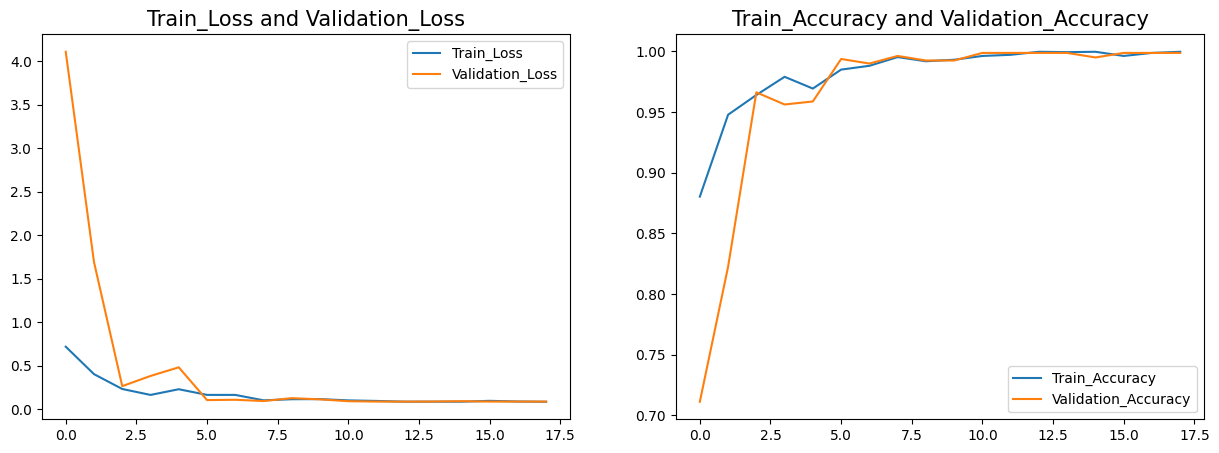

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_resnet50['loss'],label='Train_Loss')
plt.plot(history_resnet50['val_loss'],label='Validation_Loss')
plt.title('Train_Loss and Validation_Loss',fontsize=15)
plt.legend()


plt.subplot(1,2,2)
plt.plot(history_resnet50['accuracy'],label='Train_Accuracy')
plt.plot(history_resnet50['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy and Validation_Accuracy',fontsize=15)
plt.legend()
plt.show()

In [ ]:
x_val=[]
y_val=[]
y_pred=[]

for images, labels in val_data:
    x_val.extend(images.numpy())
    y_val.extend(labels.numpy())


predictions=model.predict(np.array(x_val))
for i in predictions:
    y_pred.append(np.argmax(i))

25/25 [==============================] - 3s 93ms/step


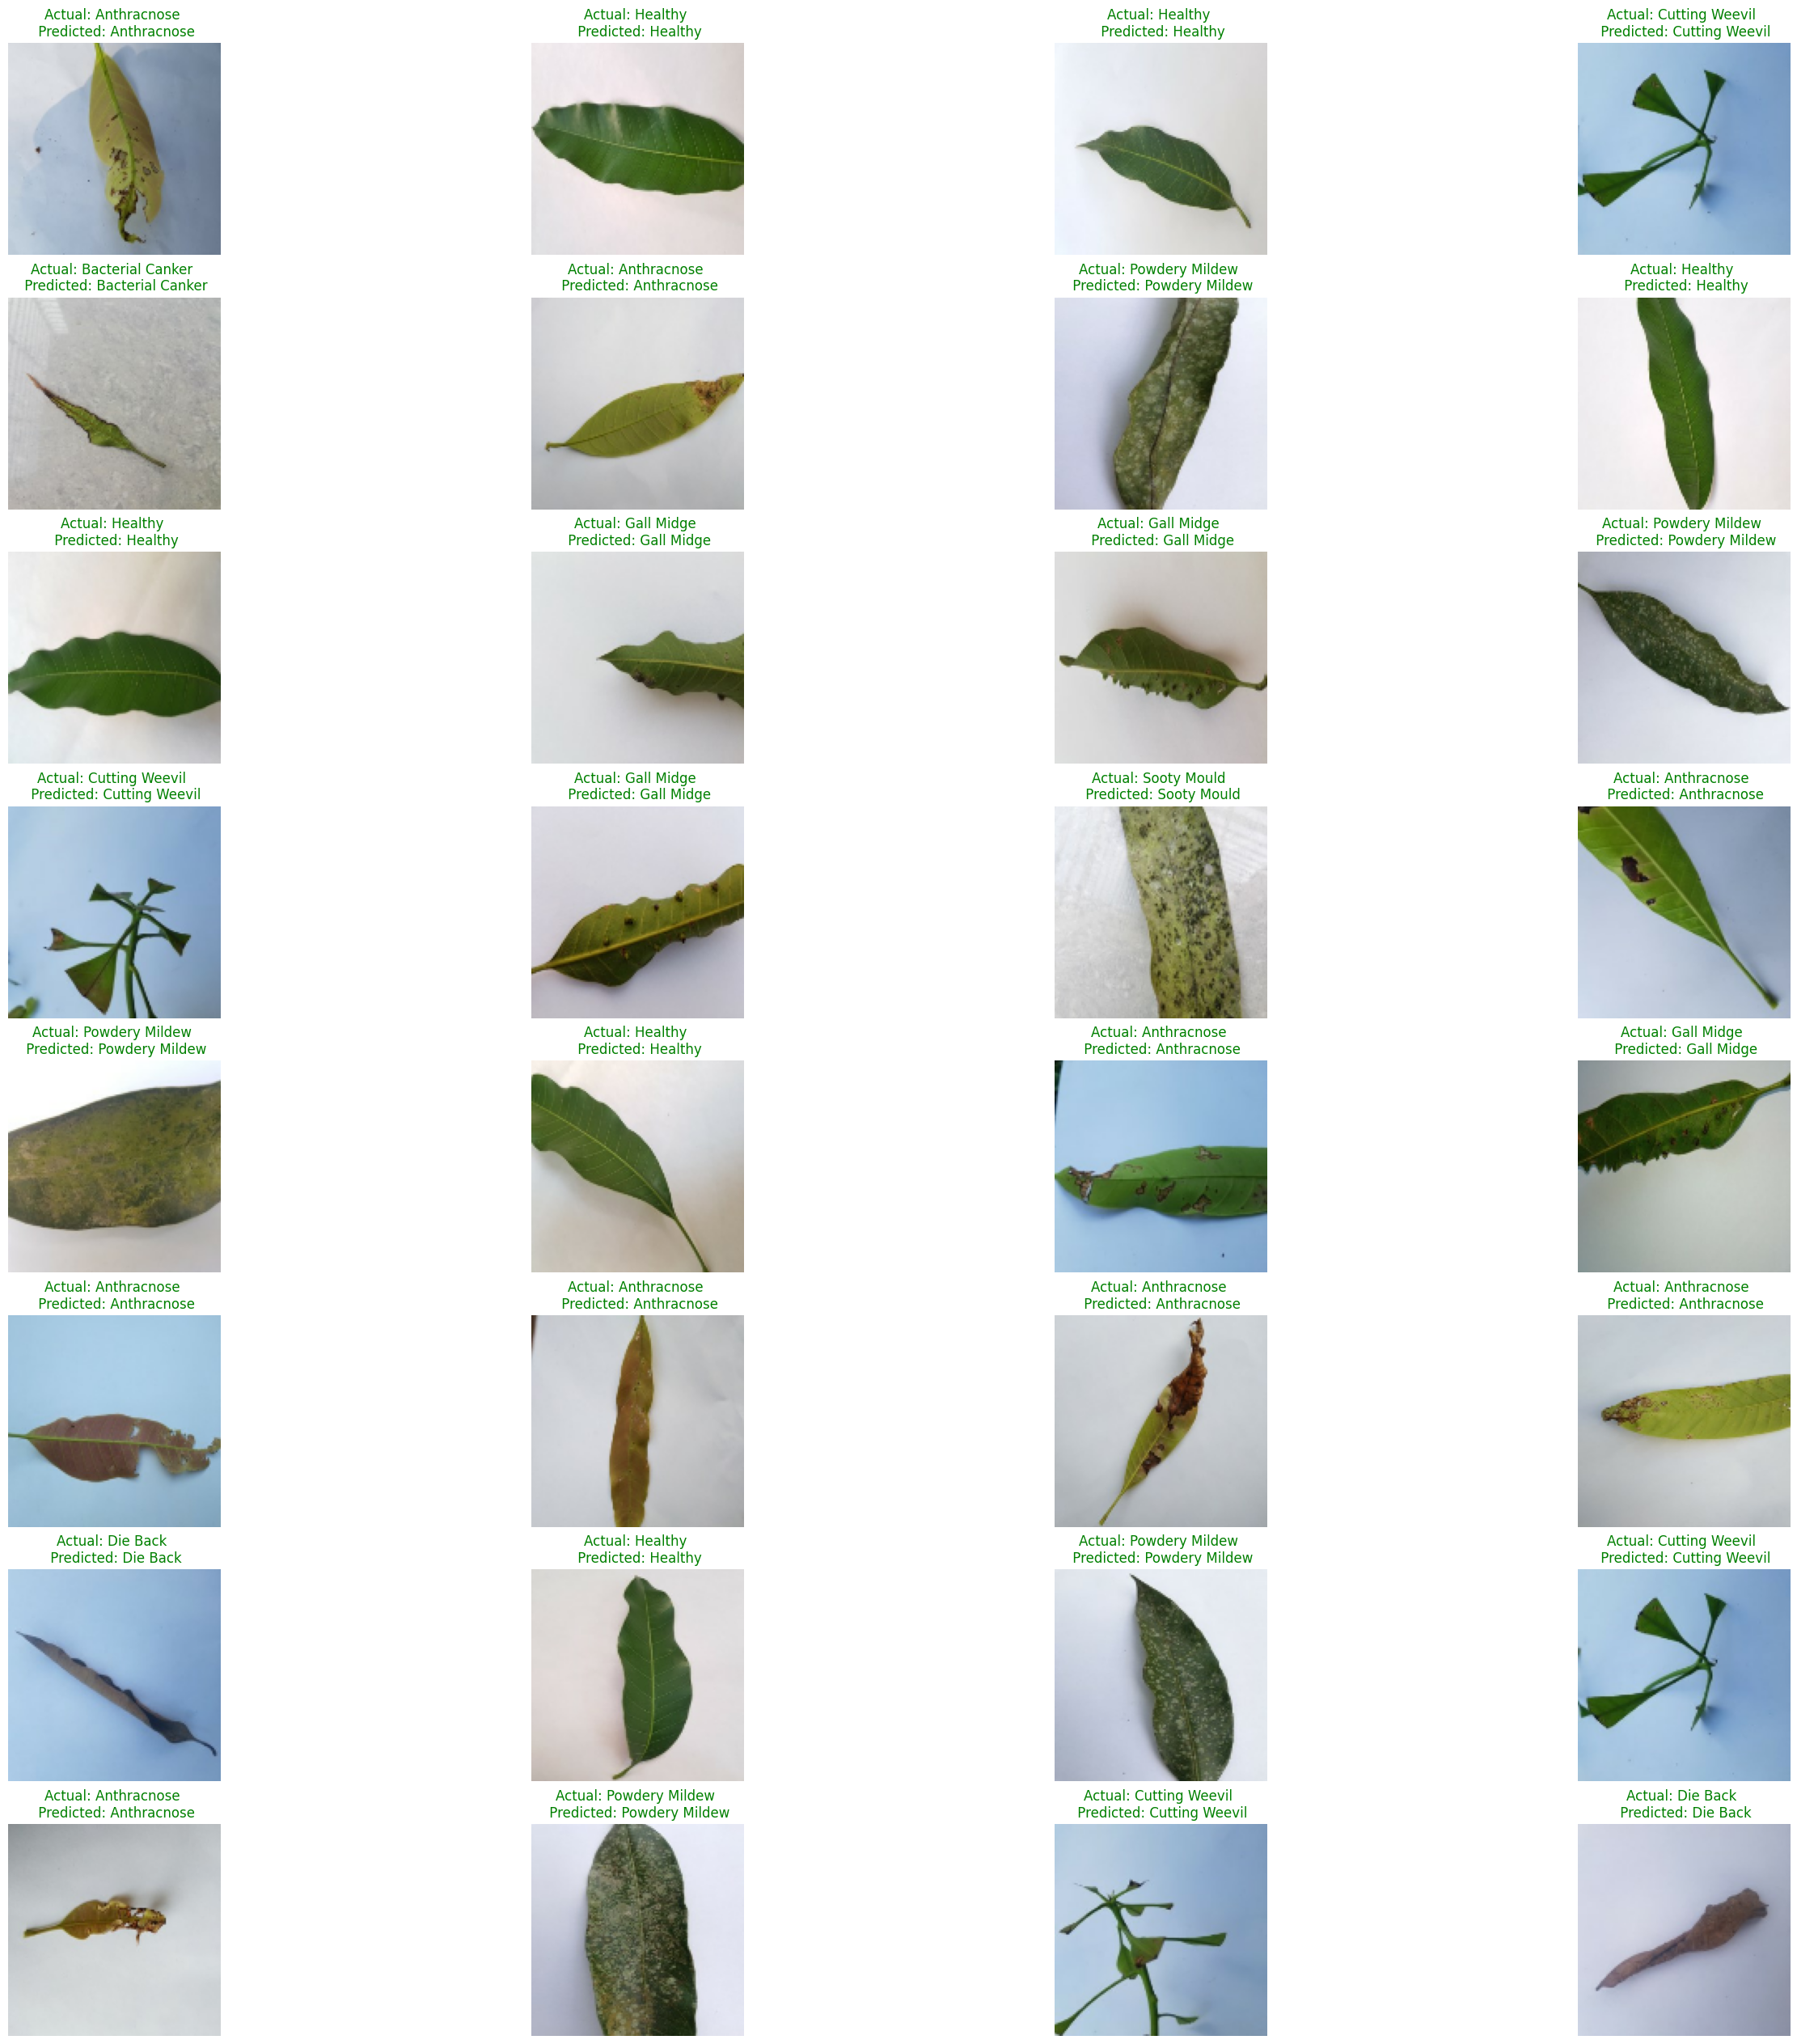

In [ ]:
plt.figure(figsize=(32, 32))

for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(x_val[i].astype("uint8"))
    actual_label = class_names[y_val[i]]
    predicted_label = class_names[y_pred[i]]

    # Check if the actual and predicted labels are the same
    if actual_label == predicted_label:
        label_color = 'green'
    else:
        label_color = 'red'

    plt.title(f'Actual: {actual_label} \n Predicted: {predicted_label}', color=label_color)
    plt.axis("off")

plt.show()